In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.animation as animation
from scipy import stats
from datetime import date

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
k = 0.0172020989 # Gaussian Grav Constant
grav = k**2 # work in units of AU, DAYS and solar masses
rsun_to_AU = 0.00465047
gm = 2.959122083e-4
rEarth = 6370.# km
rEarth_to_rSun = 0.0091577

mstar = 0.359#MSun
Rstar = 0.4445
Rplanet = 2.6*rEarth_to_rSun
#Rp_Rs = np.sqrt(np.pi/4)*0.054
Rp_Rs = 0.054
tdepth_ = Rp_Rs**2
Pplanet = 32.93963#days
b = 0.#0.774
Prot = 38.6*24.#hours

aplanet = (Pplanet**(2./3.))*((grav*mstar)**(1./3.))/((2.*np.pi)**(2./3.))

tdur_days = (Pplanet/np.pi)*np.arcsin(np.sqrt((Rstar**2 + Rplanet**2) + b**2)/(aplanet/rsun_to_AU))
tdur_hrs = tdur_days*24.
tdur_hrs = 2.7 # Kruse et al. 2019

print('tdur [calc] =', "%0.2f" % tdur_hrs, 'hours')
print('tdur [Kruse 2019] = 2.7 hours')
print('Prot(star) = ', Prot, '[hours]')

#star rotation of 1 degree in (1./360.)*Prot hours
Prot_1hr = (1./360.)*Prot
print('1 degree stellar rotation =', Prot_1hr, 'hours')
print('1 degree stellar rotation =', Prot_1hr/tdur_hrs, 'transit duration')
#
HST_orbit_ = 5./6.#0.001*Pplanet*24# In hours
HST_orbits_per_degree_stellar_rotation = Prot_1hr/HST_orbit_
Degrees_stellar_rotation_per_HST_orbit_ = 1./HST_orbits_per_degree_stellar_rotation
print()
print('1 HST orbit =', HST_orbit_, 'hours (FIXED!!)')
print('1 transit duration =', tdur_hrs/HST_orbit_, 'HST orbits')
print('1 degree stellar rotation =', HST_orbits_per_degree_stellar_rotation, 'HST orbits')
print('1 HST orbit =', Degrees_stellar_rotation_per_HST_orbit_, 'degrees stellar rotation')
#print('6 HST orbit = ', 6*obs_duration_, 'hours')
star_size = 750 # pixels, FIXED!
print('1 HST orbit =', star_size/(tdur_hrs/HST_orbit_), 'pixels traveled across star')
pixels_per_HST_visit_round_of_10 = int((star_size/(tdur_hrs/HST_orbit_) // 10)*10)
print('1 HST orbit =', pixels_per_HST_visit_round_of_10, 'pixels traveled across star (FIXED!!!)')

tdur [calc] = 2.70 hours
tdur [Kruse 2019] = 2.7 hours
Prot(star) =  926.4000000000001 [hours]
1 degree stellar rotation = 2.5733333333333337 hours
1 degree stellar rotation = 0.9530864197530865 transit duration

1 HST orbit = 0.8333333333333334 hours (FIXED!!)
1 transit duration = 3.24 HST orbits
1 degree stellar rotation = 3.088 HST orbits
1 HST orbit = 0.3238341968911917 degrees stellar rotation
1 HST orbit = 231.48148148148147 pixels traveled across star
1 HST orbit = 230 pixels traveled across star (FIXED!!!)


In [3]:
#aa = ((star_size/(tdur_hrs/HST_orbit_)) // 10)*10
#print(aa)

In [4]:
amplitude_mag = 10e-3# magnitude
amplitude_flux = 10**(-0.4*amplitude_mag)

amplitude_flux

0.9908319448927676

In [5]:
Teff_ = 3500
Tspots = 3000
#
UV_min, UV_max, IR_min, IR_max = 0.42, 0.88, 0.9, 1.8 # in micron
spectral_resolution = 500
#
area_covered, number_of_spots, aspect_ratio = 0.05, 20, 1.
#
number_of_rotation_phases = 1440#360
#
HST_filter = [1.12,1.63]
#HST_filter_=np.array([1.135,1.165,1.195,1.225,1.255,1.285,1.315,1.345,1.375,1.405,1.435,1.465,1.495,\
#                    1.525,1.555,1.585,1.615])
IR_min, IR_max = min(HST_filter), max(HST_filter)

In [6]:
#url = 'https://phoenix.ens-lyon.fr/Grids/BT-Settl/CIFIST2011_2015/SPECTRA/'
#url = 'https://phoenix.ens-lyon.fr/Grids/AMES-Dusty/SPECTRA/'
#fn = 'lte0' + str(int(Teff_/100)) + '.0-5.0-0.0a+0.0.BT-Settl.spec.7.xz'
#fn = 'lte' + str(int(Teff_/100)) + '-5.0-0.0.AMES-dusty.7.gz'
#tt = 'https://phoenix.ens-lyon.fr/Grids/AMES-Dusty/SPECTRA/lte35-5.0-0.0.AMES-dusty.7.gz'
#print(url+fn)
#print(tt)
#df = pd.read_csv(url+fn, na_filter= False).values

In [7]:
fn_model_Teff = f"T{Teff_}_g5.0_solar.txt"
fn_model_spots = f"T{Tspots}_g5.0_solar.txt"
#
stellar_spec_Teff = pd.read_csv(fn_model_Teff, header = 7, sep = '\t')
stellar_spec_Teff = stellar_spec_Teff.values
wavelength_model_Teff = stellar_spec_Teff[:,0]
stellar_flux_model_Teff = stellar_spec_Teff[:,1]
#
stellar_spec_spots = pd.read_csv(fn_model_spots, header = 7, sep = '\t')
stellar_spec_spots = stellar_spec_spots.values
wavelength_model_spots = stellar_spec_spots[:,0]
stellar_flux_model_spots = stellar_spec_spots[:,1]

In [8]:
interp_model_spectra_ = 'n'

if interp_model_spectra_ == 'y':
    print('Model Spectra Interpolated to Spectral Resolution of ' + str(spectral_resolution))
    filter_UV = np.linspace(UV_min, UV_max, spectral_resolution)
    filter_IR = np.linspace(IR_min, IR_max, spectral_resolution)
#
    stellar_flux_model_interp_Teff_IR = np.interp(filter_IR, wavelength_model_Teff/1e4, stellar_flux_model_Teff)
    stellar_flux_model_interp_spots_IR = np.interp(filter_IR, wavelength_model_spots/1e4, stellar_flux_model_spots)
#
    stellar_flux_model_interp_Teff_UV = np.interp(filter_UV, wavelength_model_Teff/1e4, stellar_flux_model_Teff)
    stellar_flux_model_interp_spots_UV = np.interp(filter_UV, wavelength_model_spots/1e4, stellar_flux_model_spots)
else:
    idx_UV_, = np.where((wavelength_model_Teff/1e4 >= UV_min) & (wavelength_model_Teff/1e4 <= UV_max))
    idx_IR_, = np.where((wavelength_model_Teff/1e4 >= IR_min) & (wavelength_model_Teff/1e4 <= IR_max))
#
    filter_UV = wavelength_model_Teff[idx_UV_]/1e4
    filter_IR = wavelength_model_Teff[idx_IR_]/1e4
#
    stellar_flux_model_interp_Teff_IR = stellar_flux_model_Teff[idx_IR_]
    stellar_flux_model_interp_spots_IR = stellar_flux_model_spots[idx_IR_]
#
    stellar_flux_model_interp_Teff_UV = stellar_flux_model_Teff[idx_UV_]
    stellar_flux_model_interp_spots_UV = stellar_flux_model_spots[idx_UV_]

In [9]:
#Sep 2019 Benneke submission: depths_Benneke, depth_err_ = \
#np.array([2937, 2886, 2874, 2912, 2913, 2897, 2901, 2970, 2955, \
#2952, 2978, 2914,2929, 2893, 2862, 2897, 2884]), 30.+np.zeros((17))

# Dec 2019 Benneke accepted:
depths_Benneke, depth_err_ = np.array([2916, 2900, 2873, 2910, 2909, 2898, 2897, 2970, 2955, 2953, 2971, 2907, \
                                       2934, 2891, 2869, 2896, 2878]), 25.+np.zeros((17))
    
depths_Tsiaras, depth_err_ = np.array([2905, 2939, 2903, 2922, 2891, 2897, 2919, 2965, 2955, 2976, 2990, 2895, \
                                       2930, 2921, 2875, 2927, 2925]), 30.+np.zeros((17))
idx_HST, = np.where((filter_IR >= min(HST_filter)) & (filter_IR <= max(HST_filter)))

HST_depths_ = depths_Benneke
#HST_depths_ = depths_Tsiaras

normalized_HST_depths_ = HST_depths_# - np.nanmean(HST_depths_)

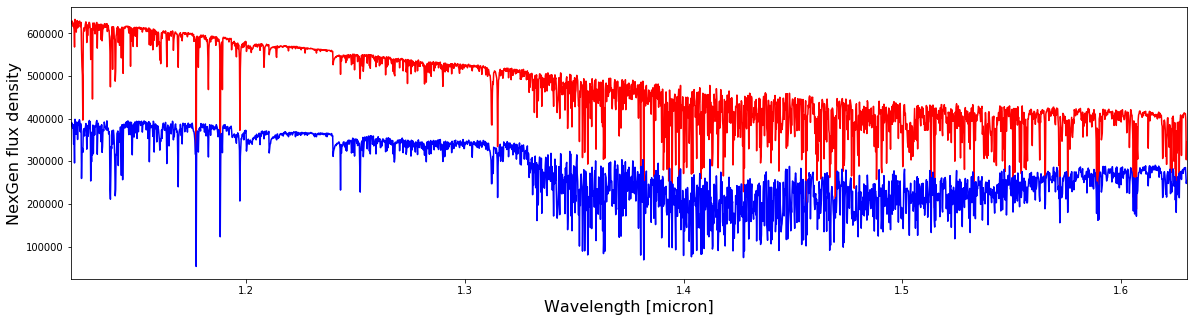

In [10]:
fig = plt.figure(figsize=(20,5))

#plt.plot(filter_UV, stellar_flux_model_interp_Teff_UV, 'b')
plt.plot(filter_IR, stellar_flux_model_interp_Teff_IR, 'r')
plt.plot(filter_IR, stellar_flux_model_interp_spots_IR, 'b')
plt.xlabel('Wavelength [micron]', fontsize = 16)
plt.ylabel('NexGen flux density', fontsize = 16)
#plt.plot(filter_IR, stellar_flux_model_interp_Teff_IR - stellar_flux_model_interp_spots_IR)
plt.xlim(HST_filter[0], HST_filter[1])
#plt.ylim(0.,2e3)

plt.show()

In [11]:
#### MAKE FIGURES ####

def fig_rotated_star_map_(phase_,\
                          star_cube_orbit_1,star_cube_orbit_2,star_cube_orbit_3,star_cube_orbit_4,\
                          nn,ii,observations_per_orbit_,save_fig):
        
    for kk in range(observations_per_orbit_):
        fig = plt.figure(figsize=(20,10))
        grid = plt.GridSpec(observations_per_orbit_, 4, wspace=0., hspace=0.)
                
        plt.subplot(grid[kk,0])
        plt.imshow(star_cube_orbit_1[:,:,kk], cmap='hot', vmin=-1., vmax=1.)
        plt.axis('off')
        if kk == 0:
            plt.title('Visit ' + str(ii+1) + '; Orbit 1')
            
        plt.subplot(grid[kk,1])
        plt.imshow(star_cube_orbit_2[:,:,kk], cmap='hot', vmin=-1., vmax=1.)
        plt.axis('off')
        if kk == 0:
            plt.title('Visit ' + str(ii+1) + '; Orbit 2')
            
        plt.subplot(grid[kk,2])
        plt.imshow(star_cube_orbit_3[:,:,kk], cmap='hot', vmin=-1., vmax=1.)
        plt.axis('off')
        if kk == 0:
            plt.title('Visit ' + str(ii+1) + '; Orbit 3')
            
        plt.subplot(grid[kk,3])
        plt.imshow(star_cube_orbit_4[:,:,kk], cmap='hot', vmin=-1., vmax=1.)
        plt.axis('off')
        if kk == 0:
            plt.title('Visit ' + str(ii+1) + '; Orbit 4')

            
#            plt.title('Rot. Phase = ' + str(round(phase_[jj],2)))

#            plt.show()
    if save_fig == 'y':
        plt.savefig(str(nn) + '_star_visit_' + str(ii+1) + '.png')
#    else:
#        plt.show()

    return
    
def fig_full_lc_(phase_full_rotation, lc_full, phase_, lc_transit, nn, ii, save_fig):                
    fig = plt.figure(figsize=(20,3))
    plt.plot(phase_full_rotation/360., lc_full, 'ko-')#, ms = 12)
    plt.plot(phase_/360., lc_transit, 'r-')#, ms = 10)
#                plt.xlim(-0.001, 0.004)
#                plt.ylim(0.995, 1.005)
    plt.title('Norm. Lightcurve, Visit ' + str(ii+1))
    plt.xlabel('Phase')
#            else:

    left, bottom, width, height = [0.65, 0.65, 0.15, 0.2]
    ax2 = fig.add_axes([left, bottom, width, height])
#                ax2.plot(phase_full_rotation/360., lc_full, 'k.')
    ax2.plot(phase_/360., lc_transit, 'ro-')#, ms = 10)
    plt.xlim(0.995*min(phase_/360.), 1.005*max(phase_/360.))
    plt.ylim(0.995*min(lc_transit), 1.005*max(lc_transit))
#    plt.xlabel('Phase')
                        
#            plt.imshow(star_map_copy_, cmap='hot', vmin=-1., vmax=1., origin = 'bottom')
#            plt.xlabel('Lon [deg]', fontsize = 12)
#            plt.ylabel('Lat [deg]', fontsize = 12)
#            plt.show()
    if save_fig == 'y':
        path_ = '/Users/vkostov/Desktop/Ideas_etc/Mapping/for_Overleaf/'
        plt.savefig(path_ + 'RandomMap_' + str(int(area_covered*100)) + 'percent_SpotCoverage_' \
                    + str(nn) + '_LcVisit_' + str(ii+1) + '.png')
    else:
        plt.show()
        
    return

def fig_plot_individual_visits(number_of_visits_, filter_IR_HST, mean_subtracted_diff_flux_arr_, \
                              bin_centers_, mean_subtracted_binned_spec_per_visit, nn, save_fig):
    fig = plt.figure(figsize=(20,15))

    for jj in range(number_of_visits_):

        plt.subplot(number_of_visits_, 1, jj+1)
        plt.plot(filter_IR[idx_HST], mean_subtracted_diff_flux_arr_[jj,:], 'k', alpha = 0.25)
        plt.plot(bin_centers_, mean_subtracted_binned_spec_per_visit[jj,:],'ro-',ms=10)
        plt.title('Diff spectrum, Visit ' + str(jj+1))
            
#        plt.show()
    if save_fig == 'y':
        path_ = '/Users/vkostov/Desktop/Ideas_etc/Mapping/for_Overleaf/'
        plt.savefig(path_ + 'Individual_visits_iter_' + str(nn) + '.png')
    else:
        plt.show()
        
    return

def fig_plot_averaged_spec_all_visits_(bin_centers_, averaged_spec_all_visits_binned_, normalized_HST_depths_,\
                                       nn, save_fig):
    fig = plt.figure(figsize=(20,3))
    plt.plot(bin_centers_, averaged_spec_all_visits_binned_, 'rs-', ms = 7, lw = 15, alpha = 0.5)
    plt.errorbar(bin_centers_, normalized_HST_depths_, yerr = 1.*depth_err_, fmt = 'bs-', ms = 7, \
                    label = 'K2-18 HST', lw = 15, alpha = 0.5)
        
    plt.title('Averaged Difference Spectrum, (OOT-ITR)/ITR)')
#        plt.show()
    if save_fig == 'y':
        path_ = '/Users/vkostov/Desktop/Ideas_etc/Mapping/for_Overleaf/'
        plt.savefig(path_ + 'Averaged_spec_all_visits_iter_' + str(nn) + '.png')
    else:
        plt.show()
    
    return

In [12]:
def spot_sizes(area_covered, ndc, aspect_ratio):
    
    Atot = np.round(4.*np.pi*rEarth**2)
    rad = np.random.random(ndc)   
    ntot = np.sum((np.pi*(rad**2))/aspect_ratio)
    normalization = Atot*area_covered/ntot
    
    rad_real = np.around(rad*(normalization**0.5))
    
    return rad_real

In [14]:
def create_photosphere_map(spot_sizes_, faculae_size, lon, lat, photosphere_id, spots_id):

    fig = plt.figure(figsize=[5.,2.5], dpi = 72)# This makes a 360x180 map in Jupyter. Brute force, but it works...
    proj = ccrs.PlateCarree()
    ax = plt.axes(projection = proj, fc = 'r')
    
    canvas = FigureCanvas(fig)    
    plt.gca().set_position([0, 0, 1, 1])
    
    ax.set_global()
    ax.outline_patch.set_linewidth(0.)
    ax.set_extent([-180, 180, -90, 90])

    for ii in range(len(spot_sizes_)):

#        add_faculae=ax.tissot(rad_km=faculae_size[ii], lons=lon[ii], lats=lat[ii], n_samples=500, fc='b', alpha=0.5)
        add_spots = ax.tissot(rad_km=spot_sizes_[ii], lons=lon[ii], lats=lat[ii], n_samples=500, fc='r', alpha=0.1)
#         XXXXXX
#         THIS IS WRONG!!!!
        
    canvas.draw()       # draw the canvas, cache the renderer 
    s, (width, height) = canvas.print_to_buffer() 
#    img_ = np.fromstring(s, np.uint8).reshape((height, width, 4))
    img_ = np.frombuffer(s, np.uint8).reshape((height, width, 4))
        
#    photosphere_id = 0.25
#    spots_id = 0.04          
    photosphere = 1. + np.zeros((img_.shape[0],img_.shape[1]))
    photosphere[img_[:,:,3] != 0] = photosphere_id#0.05
    photosphere[img_[:,:,2] != 255] = spots_id#0.45
        
    plt.close()
#    plt.show()
    return photosphere

In [15]:
#photosphere_id = 0.25
#spots_id = 0.04 
#planet_id = -1.
#spot_lat_ = -60. + 120*np.random.random(number_of_spots)
#spot_lon_ = -180 + 360.*np.random.random(number_of_spots)
#spot_sizes_ = spot_sizes(area_covered, number_of_spots, aspect_ratio)
#faculae_size = 1.5*spot_sizes_
#star_map = create_photosphere_map(spot_sizes_, faculae_size, spot_lon_, spot_lat_, photosphere_id, spots_id)
#print(star_map.shape)
#plt.imshow(star_map)

In [16]:
def rotate_star(star_map, lon, do_plot_, add_planet_, photosphere_id, spots_id):

    n_rot_phases = len(lon)
#    lon = np.linspace(0.,360, n_rot_phases)

    proj = ccrs.Orthographic(central_longitude=0., central_latitude=0.)
    
    tmp_arr = np.zeros((750,750,n_rot_phases))
    
    for ii in range(n_rot_phases):
        if ii != 180.:
            lon_min_, lon_max_ = -180+lon[ii], 180+lon[ii]
        else:
            lon_min_, lon_max_ = -180+lon[ii]+1e-1, 180+lon[ii]+1e-1
        
        plt.figure(figsize=(5,5))
        ax = plt.axes(projection = proj, fc = 'r')
        ax.outline_patch.set_linewidth(0.)

        aa = ax.imshow(star_map, origin='upper', transform=ccrs.PlateCarree(), extent=[lon_min_, lon_max_, -90, 90], \
                    cmap='hot', vmin=-1., vmax=1.)
        img_ = aa.get_array()        
        photosphere = 1. + np.zeros((img_.shape[0],img_.shape[1]))
#        photosphere_id = 0.25
#        spots_id = 0.04 
        photosphere[img_ == photosphere_id] = photosphere_id
        photosphere[img_ == spots_id] = spots_id
        
        tmp_arr[:,:,ii] = photosphere        
        
#        rr_ = (Rp_Rs*star_cube.shape[0])
#        center_ = int(0.5*star_cube.shape[0])
#        print(rr_, center_)    
#        star_cube[center_ - rr_:center_ + rr_, 300:360, ii] = planet_id
                
        if do_plot_ == 'y':
            plt.show()
        else:
            plt.close()
            
    return tmp_arr

In [17]:
def fraction_covered_(star_cube, number_of_rotation_phases, photosphere_id, spots_id, planet_id):
    
    photosphere = photosphere_id
    spots = spots_id
    planet = planet_id
    frac_photosphere = np.zeros(number_of_rotation_phases)
    frac_spots = np.zeros(number_of_rotation_phases)
    frac_planet = np.zeros(number_of_rotation_phases)
    
    for ii in range(number_of_rotation_phases):
        area_visible_disk = star_cube[:,:,ii].copy()
        area_visible_disk = star_cube[:,:,ii][star_cube[:,:,ii] != 1.].size
        
        frac_photosphere[ii] = float(star_cube[:,:,ii][star_cube[:,:,ii] == photosphere].size)
        frac_photosphere[ii] = frac_photosphere[ii]/area_visible_disk
        
        frac_spots[ii] = float(star_cube[:,:,ii][star_cube[:,:,ii] == spots].size)
        frac_spots[ii] = frac_spots[ii]/area_visible_disk
        
        frac_planet[ii] = float(star_cube[:,:,ii][star_cube[:,:,ii] == planet].size)
        frac_planet[ii] = frac_planet[ii]/area_visible_disk
                
#    print(frac_photosphere)
#    print(frac_spots)
#    print(frac_planet)
#    print(frac_photosphere + frac_spots + frac_planet)
    
    return frac_photosphere, frac_spots, frac_planet

In [18]:
def make_flux_cube(star_cube, number_of_rotation_phases, photosphere_id, spots_id, planet_id):    
    frac_photosphere, frac_spots, frac_planet = \
    fraction_covered_(star_cube, number_of_rotation_phases, photosphere_id, spots_id, planet_id)
    frac_covered = np.vstack((frac_photosphere, frac_spots)).T
    
#    print(frac_photosphere)
#    print(frac_spots)
#    print(frac_planet)
#    print()

#    lc_IR = frac_covered[:,0]*np.sum(stellar_flux_model_interp_Teff_IR) + \
#    frac_covered[:,1]*np.sum(stellar_flux_model_interp_spots_IR)
#    phase_max_ = lc_IR.argmax()
#    phase_min_ = lc_IR.argmin()
#
    flux_cube = np.zeros((number_of_rotation_phases, len(stellar_flux_model_interp_Teff_IR)))

    for ii in range(number_of_rotation_phases):
        flux_cube[ii,:] = frac_covered[ii,0]*stellar_flux_model_interp_Teff_IR + \
        frac_covered[ii,1]*stellar_flux_model_interp_spots_IR
#
    rot_phase_ = np.linspace(0.,360, number_of_rotation_phases)/360.
    
    return flux_cube 

In [19]:
def make_diff_flux_(ii, tdepth_,flux_cube_orbit_1, flux_cube_orbit_2, flux_cube_orbit_3, flux_cube_orbit_4, idx_HST):

    if (ii+1 != 4) & (ii+1 != 8):                    
        itr_flux_ = (1.-0.*tdepth_)*np.mean(np.vstack((flux_cube_orbit_2,flux_cube_orbit_3)), axis = 0)
        oot_flux_ = np.mean(np.vstack((flux_cube_orbit_1,flux_cube_orbit_4)), axis = 0)  
    if ii+1 == 4:
        itr_flux_ = (1.-0.*tdepth_)*np.mean(flux_cube_orbit_3, axis = 0)
        oot_flux_ = np.mean(np.vstack((flux_cube_orbit_1,flux_cube_orbit_3,flux_cube_orbit_4)), axis = 0)  
    if ii+1 == 8:
        itr_flux_ = (1.-0.*tdepth_)*np.mean(np.vstack((flux_cube_orbit_3,flux_cube_orbit_4)), axis = 0)
        oot_flux_ = np.mean(np.vstack((flux_cube_orbit_1,flux_cube_orbit_2)), axis = 0)
#
    diff_flux_ = 1e6*(oot_flux_[idx_HST] - itr_flux_[idx_HST])/oot_flux_[idx_HST]
#    diff_flux_arr_[ii,:] = 1e6*(oot_flux_[idx_HST] - itr_flux_[idx_HST])/itr_flux_[idx_HST]

    return diff_flux_

In [20]:
def add_two_planet_transits_(ii, star_cube_t1, star_cube_t2, observations_per_orbit_):
    
    area_visible_disk = star_cube_t1[:,:,0][star_cube_t1[:,:,0] != 1.].size
#    rr_ = int(Rp_Rs*0.5*star_cube.shape[0])
    rr_ = int(0.5*np.ceil(np.sqrt(area_visible_disk*Rp_Rs**2)))
    center_ = int(0.5*star_cube.shape[0])
    pixels_per_obs_ = int(pixels_per_HST_visit_round_of_10/(observations_per_orbit_-1))
#    pixels_per_obs_ = 50 # FIXED
#
    if ii+1 != 8:        
        for oo in range(observations_per_orbit_):            
#            obs_2_indiv_ = center_-125 + (oo-5)*pixels_per_obs_
#            obs_3_indiv_ = center_+125 + (oo-5)*pixels_per_obs_
            obs_2_indiv_ = center_-25 + (oo-observations_per_orbit_)*pixels_per_obs_
            obs_3_indiv_ = center_+(-25+425) + (oo-observations_per_orbit_)*pixels_per_obs_            
#            print(pixels_per_obs_, obs_2_indiv_, obs_3_indiv_)  

            star_cube_t1[center_-rr_:center_+rr_, obs_2_indiv_-rr_:obs_2_indiv_+rr_, oo] = planet_id
            star_cube_t2[center_-rr_:center_+rr_, obs_3_indiv_-rr_:obs_3_indiv_+rr_, oo] = planet_id
#            print(rr_)
#            print(star_cube_t1.shape)
#            area_visible_disk = star_cube_t1[:,:,oo][star_cube_t1[:,:,oo] != 1.].size
#            area_planet = star_cube_t1[:,:,oo][star_cube_t1[:,:,oo] == planet_id].size
#            print(area_visible_disk, area_planet, area_planet/area_visible_disk)
#            print(star_cube_t1[center_-rr_:center_+rr_, obs_2_indiv_-rr_:obs_2_indiv_+rr_, oo].shape)
#        xxx            
    else:
        for oo in range(observations_per_orbit_):              
#            obs_3_indiv_ = center_-125 + (oo-5)*pixels_per_obs_
#            obs_4_indiv_ = center_+125  + (oo-5)*pixels_per_obs_
            obs_3_indiv_ = center_-25 + (oo-observations_per_orbit_)*pixels_per_obs_
            obs_4_indiv_ = center_+(-25+425) + (oo-observations_per_orbit_)*pixels_per_obs_            

            star_cube_t1[center_-rr_:center_+rr_, obs_3_indiv_-rr_:obs_3_indiv_+rr_, oo] = planet_id
            star_cube_t2[center_-rr_:center_+rr_, obs_4_indiv_-rr_:obs_4_indiv_+rr_, oo] = planet_id
        
#   for oo in range(observations_per_orbit_):        
#       fig = plt.figure(figsize=(10,5))
#       grid = plt.GridSpec(observations_per_orbit_, 2, wspace=0.3, hspace=0.3)
#       plt.subplot(grid[oo,0])
#       plt.imshow(star_cube_orbit_2[:,:,oo])
            
#       plt.subplot(grid[oo,1])
#       plt.imshow(star_cube_orbit_3[:,:,oo])
#       plt.show()
    
    return star_cube_t1, star_cube_t2

In [21]:
def add_one_planet_transits_(ii, star_cube, observations_per_orbit_):
    
    area_visible_disk = star_cube[:,:,0][star_cube[:,:,0] != 1.].size
#    rr_ = int(Rp_Rs*0.5*star_cube.shape[0])
    rr_ = int(0.5*np.ceil(np.sqrt(area_visible_disk*Rp_Rs**2)))
    center_ = int(0.5*star_cube.shape[0])
    pixels_per_obs_ = int(pixels_per_HST_visit_round_of_10/(observations_per_orbit_-1))
#    pixels_per_obs_ = 50 # FIXED
#
    for oo in range(observations_per_orbit_):
        obs_3_indiv_ = center_ + (oo-observations_per_orbit_)*pixels_per_obs_
        star_cube[center_-rr_:center_+rr_, obs_3_indiv_-rr_:obs_3_indiv_+rr_, oo] = planet_id           
    
    return star_cube

In [22]:
def many_visits_random_photosphere(number_of_spots, area_covered, add_planet, number_of_visits_, nn, show_full_lc_, \
                                  plot_individual_visits_, show_rotated_star_map_, observations_per_orbit_):

#    number_of_visits_ = 8
    diff_flux_arr_ = np.zeros((number_of_visits_, len(idx_HST)))
    mean_subtracted_diff_flux_arr_ = np.zeros((number_of_visits_, len(idx_HST)))
    mean_subtracted_binned_spec_per_visit = np.zeros((number_of_visits_, 17))
    per_bin_errors_ = np.random.uniform(-30.,30, size = (number_of_visits_,17))

    star_map_all_visits_ = np.zeros((180, 360, number_of_visits_))
    
    photosphere_id = 0.25
    spots_id = 0.04 
    planet_id = -1.
    
    phase_transit_ = np.zeros(number_of_visits_)
    
    for ii in range(number_of_visits_):
#    
        spot_lat_ = -60. + 120*np.random.random(number_of_spots)
        spot_lon_ = -180 + 360.*np.random.random(number_of_spots)
        spot_sizes_ = spot_sizes(area_covered, number_of_spots, aspect_ratio)
        faculae_size = 1.5*spot_sizes_
        star_map = create_photosphere_map(spot_sizes_, faculae_size, spot_lon_, spot_lat_, photosphere_id, spots_id)
        star_map_all_visits_[:,:,ii] = star_map
#       
        phase_ = 2.*Degrees_stellar_rotation_per_HST_orbit_*np.linspace(0,3,4) + np.random.uniform(357.5)
        number_of_rotation_phases = len(phase_)
#        print(ii, phase_)
        
        phase_transit_[ii] = phase_[0]
        
        pp_tmp_ = Degrees_stellar_rotation_per_HST_orbit_/observations_per_orbit_        
        phases_per_orbit_ = np.zeros((len(phase_),observations_per_orbit_))
        for pp_ in range(len(phase_)):
            phases_per_orbit_[pp_,:] = phase_[pp_] + (pp_tmp_)*np.linspace(-observations_per_orbit_/2,\
                                                                           observations_per_orbit_/2,\
                                                                           observations_per_orbit_)
#            
        do_plot_ = 'n'
        star_cube_orbit_1 = rotate_star(star_map,phases_per_orbit_[0,:],do_plot_,add_planet,photosphere_id,spots_id)
        star_cube_orbit_2 = rotate_star(star_map,phases_per_orbit_[1,:],do_plot_,add_planet,photosphere_id,spots_id)
        star_cube_orbit_3 = rotate_star(star_map,phases_per_orbit_[2,:],do_plot_,add_planet,photosphere_id,spots_id)
        star_cube_orbit_4 = rotate_star(star_map,phases_per_orbit_[3,:],do_plot_,add_planet,photosphere_id,spots_id)
        
        if (ii+1 != 4) & (ii+1 != 8):
            star_cube_orbit_2, star_cube_orbit_3 = \
            add_two_planet_transits_(ii, star_cube_orbit_2, star_cube_orbit_3, observations_per_orbit_)
        if ii+1 == 4:
            star_cube_orbit_3 = \
            add_one_planet_transits_(ii, star_cube_orbit_3, observations_per_orbit_)
        if ii+1 == 8:
            star_cube_orbit_3, star_cube_orbit_4 = \
            add_two_planet_transits_(ii, star_cube_orbit_3, star_cube_orbit_4, observations_per_orbit_)
#
#
        pp_ = observations_per_orbit_
        flux_cube_orbit_1 = make_flux_cube(star_cube_orbit_1, pp_, photosphere_id, spots_id, planet_id)
        flux_cube_orbit_2 = make_flux_cube(star_cube_orbit_2, pp_, photosphere_id, spots_id, planet_id)
        flux_cube_orbit_3 = make_flux_cube(star_cube_orbit_3, pp_, photosphere_id, spots_id, planet_id)
        flux_cube_orbit_4 = make_flux_cube(star_cube_orbit_4, pp_, photosphere_id, spots_id, planet_id)
        
        diff_flux_arr_[ii,:] = \
        make_diff_flux_(ii, tdepth_,flux_cube_orbit_1, flux_cube_orbit_2, flux_cube_orbit_3, flux_cube_orbit_4, \
                        idx_HST)

        mean_subtracted_diff_flux_arr_[ii,:] = diff_flux_arr_[ii,:] - np.nanmean(diff_flux_arr_[ii,:]) 
#    
        bin_means,bin_edges,binnumber = \
        stats.binned_statistic(filter_IR[idx_HST],mean_subtracted_diff_flux_arr_[ii,:],statistic='mean', bins=17)
    
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers_ = bin_edges[1:] - bin_width/2

        mean_subtracted_binned_spec_per_visit[ii,:] =  bin_means + 0.*per_bin_errors_[ii,:]
#        
        if show_rotated_star_map_ == 'y':
            save_fig = 'n'            
            aa = fig_rotated_star_map_(phase_, \
                                       star_cube_orbit_1, star_cube_orbit_2, star_cube_orbit_3, star_cube_orbit_4, \
                                       nn, ii, observations_per_orbit_, save_fig)
#       
        if show_full_lc_ == 'y':
            save_fig = 'n'
            lc_transit_ = np.hstack((np.sum(flux_cube_orbit_1, axis = 1), 
                                    np.sum(flux_cube_orbit_2, axis = 1), 
                                    np.sum(flux_cube_orbit_3, axis = 1), 
                                    np.sum(flux_cube_orbit_4, axis = 1)))
                        
            phase_full_rotation = np.linspace(0.,359., 20)
            do_plot_
            star_cube_full_rotation = \
            rotate_star(star_map, phase_full_rotation, do_plot_, add_planet_, photosphere_id, spots_id)
            flux_cube_full_rotation = \
            make_flux_cube(star_cube_full_rotation, len(phase_full_rotation), photosphere_id, spots_id, planet_id)

            lc_full = np.zeros((flux_cube_full_rotation.shape[0]))
            for kk in range(len(lc_full)):
                lc_full[kk] = np.sum(flux_cube_full_rotation[kk,:])
                        
            aa = fig_full_lc_(phase_full_rotation, lc_full/lc_transit_[0], \
                              phases_per_orbit_.flatten(), lc_transit_/lc_transit_[0], nn, ii, save_fig)
#
#
    averaged_spec_all_visits_ = np.nanmean(mean_subtracted_diff_flux_arr_, axis = 0)
    averaged_spec_all_visits_binned_ = np.nanmean(mean_subtracted_binned_spec_per_visit, axis = 0)
#
    if plot_individual_visits_ == 'y':
        save_fig = 'y'
        aa = fig_plot_individual_visits(number_of_visits_, filter_IR[idx_HST], mean_subtracted_diff_flux_arr_, \
                              bin_centers_, mean_subtracted_binned_spec_per_visit, nn, save_fig)
#
    plot_averaged_spec_all_visits_ = 'y'
    if plot_averaged_spec_all_visits_ == 'y':
        save_fig = 'y'
        aa=fig_plot_averaged_spec_all_visits_(bin_centers_, averaged_spec_all_visits_binned_, \
                                              normalized_HST_depths_, nn, save_fig)

#    plt.savefig('tmp_1.png')
    return mean_subtracted_diff_flux_arr_,mean_subtracted_binned_spec_per_visit,bin_centers_,\
star_map_all_visits_,phase_transit_

In [23]:
def many_visits_same_photosphere(star_map,add_planet,number_of_visits_,nn,show_full_lc_,lc_full,phase_full_rotation,\
                                plot_individual_visits_, show_rotated_star_map_, load_phase_transit, phase_load, \
                                observations_per_orbit_, add_noise_):

    diff_flux_arr_ = np.zeros((number_of_visits_, len(idx_HST)))
    mean_subtracted_diff_flux_arr_ = np.zeros((number_of_visits_, len(idx_HST)))
    mean_subtracted_binned_spec_per_visit = np.zeros((number_of_visits_, 17))
    per_bin_errors_ = np.random.uniform(-30.,30, size = (number_of_visits_,17))

    photosphere_id = 0.25
    spots_id = 0.04 
    planet_id = -1.
    
    if load_phase_transit == 'n':    
        phase_transit_ = np.zeros(number_of_visits_)
        
    for ii in range(number_of_visits_):
    
        if load_phase_transit == 'n':
#            phase_ = 0.67*np.linspace(0,3,4) + np.random.uniform(357.5)
            phase_ = 2.*Degrees_stellar_rotation_per_HST_orbit_*np.linspace(0,3,4) + np.random.uniform(357.5)
            phase_transit_[ii] = phase_[0]
        else:
#            phase_ = 0.67*np.linspace(0,3,4) + phase_load[ii]
            phase_ = 2.*Degrees_stellar_rotation_per_HST_orbit_*np.linspace(0,3,4) + phase_load[ii]
            phase_transit_ = phase_load
#
#
#        observations_per_orbit_ = 2
        pp_tmp_ = Degrees_stellar_rotation_per_HST_orbit_/observations_per_orbit_
        
        phases_per_orbit_ = np.zeros((len(phase_),observations_per_orbit_))
        for pp_ in range(len(phase_)):
            phases_per_orbit_[pp_,:] = phase_[pp_] + (pp_tmp_)*np.linspace(-observations_per_orbit_/2,\
                                                                           observations_per_orbit_/2,\
                                                                           observations_per_orbit_)
#        xxxx
        
        
        do_plot_ = 'n'
        star_cube_orbit_1 = rotate_star(star_map,phases_per_orbit_[0,:],do_plot_,add_planet,photosphere_id,spots_id)
        star_cube_orbit_2 = rotate_star(star_map,phases_per_orbit_[1,:],do_plot_,add_planet,photosphere_id,spots_id)      
        star_cube_orbit_3 = rotate_star(star_map,phases_per_orbit_[2,:],do_plot_,add_planet,photosphere_id,spots_id)
        star_cube_orbit_4 = rotate_star(star_map,phases_per_orbit_[3,:],do_plot_,add_planet,photosphere_id,spots_id)
#
#
        if add_planet == 'y':
            if (ii+1 != 4) & (ii+1 != 8):
                star_cube_orbit_2, star_cube_orbit_3 = \
                add_two_planet_transits_(ii, star_cube_orbit_2, star_cube_orbit_3, observations_per_orbit_)            
            if ii+1 == 4:
                star_cube_orbit_3 = \
                add_one_planet_transits_(ii, star_cube_orbit_3, observations_per_orbit_)
            if ii+1 == 8:
                star_cube_orbit_3, star_cube_orbit_4 = \
                add_two_planet_transits_(ii, star_cube_orbit_3, star_cube_orbit_4, observations_per_orbit_)
#
#


#        plt.figure(figsize=(10,20))
#        plt.subplot(421)
#        plt.imshow(star_cube_orbit_2[:,:,0], cmap='hot', vmin=-1., vmax=1.)
        
#        plt.subplot(422)
#        plt.imshow(star_cube_orbit_3[:,:,0], cmap='hot', vmin=-1., vmax=1.)
        
#        plt.subplot(423)
#        plt.imshow(star_cube_orbit_2[:,:,1], cmap='hot', vmin=-1., vmax=1.)
        
#        plt.subplot(424)
#        plt.imshow(star_cube_orbit_3[:,:,1], cmap='hot', vmin=-1., vmax=1.)

#        plt.subplot(425)
#        plt.imshow(star_cube_orbit_2[:,:,2], cmap='hot', vmin=-1., vmax=1.)
        
#        plt.subplot(426)
#        plt.imshow(star_cube_orbit_3[:,:,2], cmap='hot', vmin=-1., vmax=1.)

#        plt.subplot(427)
#        plt.imshow(star_cube_orbit_2[:,:,3], cmap='hot', vmin=-1., vmax=1.)
        
#        plt.subplot(428)
#        plt.imshow(star_cube_orbit_3[:,:,3], cmap='hot', vmin=-1., vmax=1.)
#        xxxx
        pp_ = observations_per_orbit_    
        flux_cube_orbit_1 = make_flux_cube(star_cube_orbit_1, pp_, photosphere_id, spots_id, planet_id)
        flux_cube_orbit_2 = make_flux_cube(star_cube_orbit_2, pp_, photosphere_id, spots_id, planet_id)
        flux_cube_orbit_3 = make_flux_cube(star_cube_orbit_3, pp_, photosphere_id, spots_id, planet_id)
        flux_cube_orbit_4 = make_flux_cube(star_cube_orbit_4, pp_, photosphere_id, spots_id, planet_id)        
#
#
        diff_flux_arr_[ii,:] = make_diff_flux_(ii, tdepth_,flux_cube_orbit_1, flux_cube_orbit_2, \
                                               flux_cube_orbit_3, flux_cube_orbit_4, idx_HST)
#    
        mean_subtracted_diff_flux_arr_[ii,:] = diff_flux_arr_[ii,:] - 0.*np.nanmean(diff_flux_arr_[ii,:])
#    

#        plt.plot(diff_flux_arr_[ii,:])
#        xxxx

        bin_means,bin_edges,binnumber = \
        stats.binned_statistic(filter_IR[idx_HST],mean_subtracted_diff_flux_arr_[ii,:],statistic='mean', bins=17)
    
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers_ = bin_edges[1:] - bin_width/2

        if add_noise_ == 'y':        
            mean_subtracted_binned_spec_per_visit[ii,:] =  bin_means + 1.*per_bin_errors_[ii,:]
        else:
            mean_subtracted_binned_spec_per_visit[ii,:] =  bin_means + 0.*per_bin_errors_[ii,:]
#        
        if show_rotated_star_map_ == 'y':
            save_fig = 'n'            
            aa = fig_rotated_star_map_(phase_, \
                                       star_cube_orbit_1, star_cube_orbit_2, star_cube_orbit_3, star_cube_orbit_4, \
                                       nn, ii, observations_per_orbit_, save_fig)
#
        if show_full_lc_ == 'y':
            save_fig = 'n'
            lc_transit_ = np.hstack((np.sum(flux_cube_orbit_1, axis = 1), 
                                    np.sum(flux_cube_orbit_2, axis = 1), 
                                    np.sum(flux_cube_orbit_3, axis = 1), 
                                    np.sum(flux_cube_orbit_4, axis = 1)))
            
            aa = fig_full_lc_(phase_full_rotation, lc_full/lc_transit_[0], \
                              phases_per_orbit_.flatten(), lc_transit_/lc_transit_[0], nn, ii, save_fig)
#
#
    averaged_spec_all_visits_ = np.nanmean(mean_subtracted_diff_flux_arr_, axis = 0)
    averaged_spec_all_visits_binned_ = np.nanmean(mean_subtracted_binned_spec_per_visit, axis = 0)
#
#
    if plot_individual_visits_ == 'y':
        save_fig = 'n'
        aa = fig_plot_individual_visits(number_of_visits_, filter_IR[idx_HST], mean_subtracted_diff_flux_arr_, \
                              bin_centers_, mean_subtracted_binned_spec_per_visit, nn, save_fig)
#
    plot_averaged_spec_all_visits_ = 'y'
    if plot_averaged_spec_all_visits_ == 'y':
        save_fig = 'y'
        aa=fig_plot_averaged_spec_all_visits_(bin_centers_, averaged_spec_all_visits_binned_, \
                                              normalized_HST_depths_, nn, save_fig)
#
    return mean_subtracted_diff_flux_arr_, mean_subtracted_binned_spec_per_visit, bin_centers_, phase_transit_

In [24]:
load_chi_sq_ = 'n'

if load_chi_sq_ == 'y':
    reduced_chi_sq_ = np.load('reduced_chi_sq_42820.npy')

    min_idx_ = reduced_chi_sq_.argmin()
    spot_crossings_idx_ = np.asarray([])#0,2,3,5,7,17,21,27,30,35,39,43,44,45,46,47,62,64,65,66,74,84,85,91,98])
    print(reduced_chi_sq_, min(reduced_chi_sq_), max(reduced_chi_sq_))    
    idx_, = np.where(reduced_chi_sq_ < 17.)
    #print(len(idx_), idx_)
    
    n_bins = int(max(reduced_chi_sq_) - min(reduced_chi_sq_))
#    n_bins_spot_crossings_ = int(max(reduced_chi_sq_[spot_crossings_idx_]) - min(reduced_chi_sq_[spot_crossings_idx_]))

    fig = plt.figure(figsize=(20,5))
    plt.hist(reduced_chi_sq_, bins = 20, fc = None, ec = 'b', hatch = '\\', alpha = 0.25, label = 'All simulations')
#    plt.hist(reduced_chi_sq_[spot_crossings_idx_], bins = n_bins_spot_crossings_//1, hatch = '/', fc = None, \
#             ec = 'r', alpha = 0.25, label = \
#             'Simulations with Spot Crossings (~' + str(int(100*len(spot_crossings_idx_)/len(reduced_chi_sq_))) + '%)')
    plt.xlabel('Reduced Chi-square', fontsize = 18)
    plt.ylabel('Number of simulations', fontsize = 18)
    plt.legend(loc = 'best', fontsize = 14)
    plt.show()

In [25]:
number_of_iterations_ = 1#25
number_of_visits_ = 8
observations_per_orbit_ = 4

star_cube = np.zeros((750,750,4,number_of_iterations_))
flux_cube = np.zeros((4, 2551, number_of_iterations_))
mean_subtracted_diff_flux_arr_all_iterations_ = np.zeros((number_of_iterations_,number_of_visits_,
                                                          len(filter_IR[idx_HST])))

star_map = np.zeros((180, 360, number_of_iterations_))

phase_transit_ = np.zeros((number_of_iterations_, number_of_visits_))

photosphere_ = 'random'
photosphere_ = 'same'
load_phase_transit, load_star_map = 'y', 'y'#'n', 'n'#
add_planet_ = 'y'#'y'
add_noise_ = 'n'#'y'

show_full_lc_ = 'n'#'n'
plot_individual_visits_ = 'y'
show_rotated_star_map_ = 'y'#'y'#

for ii in range(number_of_iterations_):
    
    if photosphere_ == 'random':
    
        mean_subtracted_diff_flux_arr_,mean_subtracted_binned_spec_per_visit,bin_centers_,\
        star_map_tmp,phase_transit_tmp=many_visits_random_photosphere(number_of_spots,area_covered,add_planet_,\
                                                                      number_of_visits_,ii,show_full_lc_, \
                                                                      plot_individual_visits_, \
                                                                      show_rotated_star_map_, \
                                                                      observations_per_orbit_)        
        phase_transit_[ii, :] = phase_transit_tmp
        star_map[:,:,ii] = star_map_tmp
        
    if photosphere_ == 'same':
        
        spot_lat_ = -60. + 120*np.random.random(number_of_spots)
        spot_lon_ = -180 + 360.*np.random.random(number_of_spots)
        spot_sizes_ = spot_sizes(area_covered, number_of_spots, aspect_ratio)
        faculae_size = 1.5*spot_sizes_ # WIP
        
        photosphere_id = 0.25
        spots_id = 0.04 
        planet_id = -1.
        
        do_plot_ = 'n'
            
        if (load_phase_transit == 'n') & (load_star_map == 'n'):
            star_map_same = \
            create_photosphere_map(spot_sizes_,faculae_size,spot_lon_,spot_lat_,photosphere_id,spots_id)
            phase_transit_load = -999.
            
        else:
            star_map_file = 'star_map_file_42820.npy'#.npy'#
            phase_file = 'phase_file_42820.npy'#.npy'#_041620.npy'
            star_map_load, phase_transit_load = np.load(star_map_file), np.load(phase_file)
            
            idx_ = min_idx_#-1 FOR WATER FEATURE IN "STAR_MAP_FILE.NPY"
            star_map_same, phase_transit_load = star_map_load[:,:,idx_], phase_transit_load[idx_,:]
                        
        phase_full_rotation = np.linspace(0.,359., 2)
        
        do_plot_ = 'n'
        star_cube_full_rotation = \
        rotate_star(star_map_same, phase_full_rotation, do_plot_, add_planet_, photosphere_id, spots_id)
        flux_cube_full_rotation = \
        make_flux_cube(star_cube_full_rotation, len(phase_full_rotation), photosphere_id, spots_id, planet_id)

        lc_full = np.zeros((flux_cube_full_rotation.shape[0]))
        for kk in range(len(lc_full)):
            lc_full[kk] = np.sum(flux_cube_full_rotation[kk,:])
            
        mean_subtracted_diff_flux_arr_, mean_subtracted_binned_spec_per_visit, bin_centers_, phase_transit_tmp = \
        many_visits_same_photosphere(star_map_same, add_planet_, number_of_visits_, ii, show_full_lc_, lc_full, \
                                     phase_full_rotation, plot_individual_visits_, show_rotated_star_map_, \
                                     load_phase_transit, phase_transit_load, observations_per_orbit_,add_noise_)
        
        mean_subtracted_diff_flux_arr_all_iterations_[ii,:,:] = mean_subtracted_diff_flux_arr_
        
        phase_transit_[ii, :] = phase_transit_tmp
        
        star_map[:,:,ii] = star_map_same
    
    print('Iteration ', str(ii), '...done!')
    
save_output_ = 'n'

if save_output_ == 'y':
    today = date.today()
    star_map_file = 'star_map_file_' + str(today.month) + str(today.day) + str(today.year-2000) + '.npy'
    phase_file = 'phase_file_' + str(today.month) + str(today.day) + str(today.year-2000) + '.npy'
    np.save(star_map_file, star_map)
    np.save(phase_file, phase_transit_)

FileNotFoundError: [Errno 2] No such file or directory: 'star_map_file_42820.npy'

In [ ]:
xxx

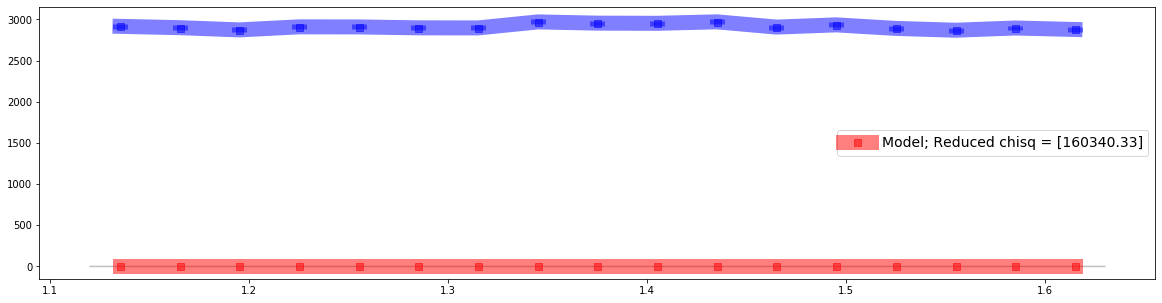

[160340.33444444]


In [26]:
mean_subtracted_binned_spec_per_visit = np.zeros((number_of_visits_, 17))
per_bin_errors_ = np.random.uniform(-25.,25., size = (number_of_visits_,17))

reduced_chi_sq_ = np.zeros((number_of_iterations_))

for jj in range(number_of_iterations_):
    mean_subtracted_diff_flux_arr_ITER_ = mean_subtracted_diff_flux_arr_all_iterations_[jj,:,:]
    averaged_spec_all_visits_ = np.nanmean(mean_subtracted_diff_flux_arr_ITER_, axis = 0)

    for vv in range(number_of_visits_):

        bin_means,bin_edges,binnumber = \
        stats.binned_statistic(filter_IR[idx_HST],mean_subtracted_diff_flux_arr_ITER_[vv,:],statistic='mean', bins=17)
    
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers_ = bin_edges[1:] - bin_width/2
    
        add_noise_per_bin_ = 'n'#'y'
        if add_noise_per_bin_ == 'y':        
            mean_subtracted_binned_spec_per_visit[vv,:] =  bin_means + 1.*per_bin_errors_[vv,:]
        else:
            mean_subtracted_binned_spec_per_visit[vv,:] =  bin_means + 0.*per_bin_errors_[vv,:]

    averaged_spec_all_visits_binned_ = np.nanmean(mean_subtracted_binned_spec_per_visit, axis = 0)

    obs = normalized_HST_depths_
    calc = averaged_spec_all_visits_binned_
    reduced_chi_sq_[jj] = np.sum(((obs - calc)/depth_err_)**2)

    fig = plt.figure(figsize=(20,5))
    plt.plot(filter_IR[idx_HST], averaged_spec_all_visits_, 'gray', alpha = 0.5)
    plt.plot(bin_centers_, averaged_spec_all_visits_binned_, 'rs-', ms = 7, lw = 15, alpha = 0.5, \
             label = 'Model; Reduced chisq = ' + str(np.round(reduced_chi_sq_,2)))
    plt.errorbar(bin_centers_, normalized_HST_depths_, yerr = 1.*depth_err_, fmt = 'bs-', ms = 7, \
                 lw = 15, alpha = 0.5)
#             label = 'K2-18 HST', lw = 15, alpha = 0.5)
    plt.legend(fontsize = 14)
    plt.show()
print(reduced_chi_sq_)
#today = date.today()
#np.save('reduced_chi_sq_' + str(today.month) + str(today.day) + str(today.year-2000) + '.npy', reduced_chi_sq_)

In [27]:
xxx

NameError: name 'xxx' is not defined

NameError: name 'star_cube_full_rotation' is not defined

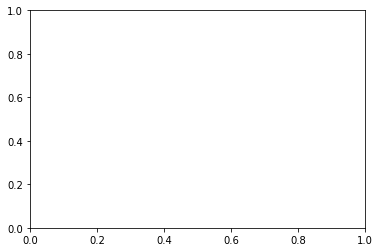

In [28]:
from matplotlib.patches import Circle

fig,ax = plt.subplots()
ax.imshow(star_cube_full_rotation[:,:,0], cmap = 'hot', vmin = -1, vmax = 1., origin = 'lower')

circ = Circle((350,460),50)
ax.add_patch(circ)

In [29]:
#benneke_model_ = pd.read_csv('Benneke_best_fit_model.csv').values

In [30]:
benneke_model_.shape

NameError: name 'benneke_model_' is not defined

array([0., 0., 0., ..., 0., 0., 0.])

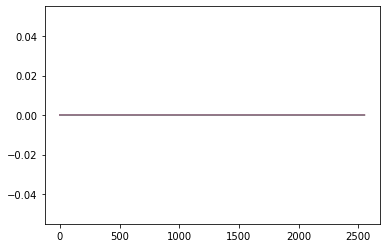

In [31]:

for vv in range(number_of_visits_):
    plt.plot(mean_subtracted_diff_flux_arr_ITER_[vv,:])
    
mean_subtracted_diff_flux_arr_ITER_[vv,:]

In [32]:
fig = plt.figure(figsize=(20,5))

bin_means,bin_edges,binnumber = \
stats.binned_statistic(filter_IR[idx_HST],mean_subtracted_diff_flux_arr_ITER_[vv,:],statistic='mean', bins=17)



plt.plot(benneke_model_[:,0], benneke_model_[:,1] - np.nanmean(benneke_model_[:,1]), '.')

NameError: name 'benneke_model_' is not defined

<Figure size 1440x360 with 0 Axes>

In [33]:
xxxx

NameError: name 'xxxx' is not defined

In [34]:
save_output_ = 'y'

if save_output_ == 'y':
    star_map_file = 'star_map_file_test.npy'
    phase_file = 'phase_file_test.npy'
    np.save(star_map_file, star_map)
    np.save(phase_file, phase_transit_)

In [35]:
xxx

NameError: name 'xxx' is not defined

In [36]:
plt.imshow(star_map_same, origin = 'lower', cmap='hot', vmin=-1., vmax=1.)
plt.xlabel('Longitude [deg]', fontsize = 14)
plt.ylabel('Latitude [deg]', fontsize = 14)

path_ = '/Users/vkostov/Desktop/Ideas_etc/Mapping/for_Overleaf/'
plt.savefig(path_ + 'RandomMap_' + str(int(area_covered*100)) + 'percent_SpotCoverage.png')

NameError: name 'star_map_same' is not defined

In [37]:
xx

NameError: name 'xx' is not defined

In [38]:
star_cube_full_rotation

%matplotlib inline
fig = plt.figure(figsize=(15,10))
n_panels = 12#number_of_rotation_phases if number_of_rotation_phases < 13 else 12

for ii in range(n_panels):
    plt.subplot(3, 4, ii+1)
    plt.imshow(star_cube_full_rotation[:,:,int(ii*(len(phase_full_rotation))/n_panels)], cmap='hot', vmin=-1., vmax=1.)
    plt.axis('off')
    plt.title('Rotation Phase = ' + str(round(ii/n_panels,2)))
    
plt.savefig(path_ + 'RandomMap_' + str(int(area_covered*100)) + 'percent_SpotCoverage_Rotation.png')

NameError: name 'star_cube_full_rotation' is not defined

In [39]:
xxx

NameError: name 'xxx' is not defined

NameError: name 'star_cube_full_rotation' is not defined

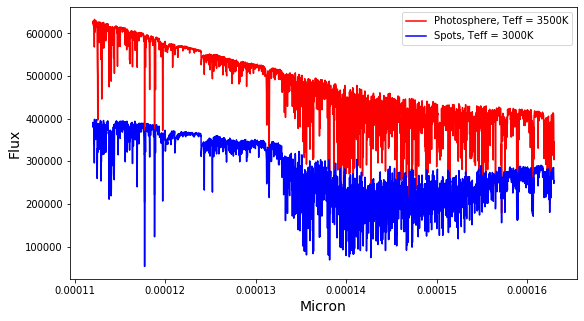

In [40]:
#plt.plot(frac_covered_[:,0])
%matplotlib inline
fig = plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(filter_IR/1e4, stellar_flux_model_interp_Teff_IR, 'r', label = 'Photosphere, Teff = ' + str(Teff_) + 'K')
plt.plot(filter_IR/1e4, stellar_flux_model_interp_spots_IR, 'b', label = 'Spots, Teff = ' + str(Tspots) + 'K')
plt.ylabel('Flux', fontsize = 14)
plt.xlabel('Micron', fontsize = 14)
plt.legend()

frac_covered = fraction_covered_(star_cube_full_rotation, len(phase_full_rotation), photosphere_id, spots_id, planet_id)
frac_covered = np.asarray(frac_covered).T

plt.subplot(122)
plt.plot(phase_full_rotation, frac_covered[:,0], 'r-', label = 'Photosphere')
plt.plot(phase_full_rotation, frac_covered[:,1], 'b-', label = 'Spots')
#for ii in range(5):
#    plt.plot(rot_phase_, frac_covered_[:,ii], label = 'Spot ' + str(ii))
plt.xlabel('Rotation Phase', fontsize = 14)
plt.ylabel('Fraction Covered', fontsize = 14)
plt.legend()

#plt.subplot(133)
#plt.plot(rot_phase_, frac_covered[:,0]*np.sum(stellar_flux_model_interp_Teff_IR), 'r', label = 'Flux, Photosphere')
#plt.plot(rot_phase_, (1.-frac_covered[:,0])*np.sum(stellar_flux_model_interp_spots_IR), 'b', label = 'Flux, Spots')
#plt.plot(rot_phase_, lc_IR, 'k', label = 'Flux, Total')
#plt.xlabel('Rotation Phase', fontsize = 14)
#plt.ylabel('Flux', fontsize = 14)
#plt.legend()

plt.savefig(path_ + 'RandomMap_' + str(int(area_covered*100)) + 'percent_SpotCoverage_FractionRotate.png')

In [41]:
xxxxxx

NameError: name 'xxxxxx' is not defined

NameError: name 'star_cube_full_rotation' is not defined

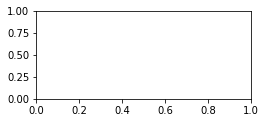

In [42]:
fig = plt.figure(figsize=(20,10))

grid = plt.GridSpec(5, 4, wspace=0.4, hspace=0.3)

plt.subplot(grid[0, 0])
bb = star_cube_full_rotation[:,:,0].copy()
plt.imshow(bb, cmap='hot', vmin=-1., vmax=1.)
plt.axis('off')
#plt.title('@max lightcurve')
del bb

plt.subplot(grid[0, 1])
bb = star_cube_full_rotation[:,:,int(0.25*len(phase_full_rotation))].copy()
plt.imshow(bb, cmap='hot', vmin=-1., vmax=1.)
#plt.title('@min lightcurve')
plt.axis('off')
del bb

plt.subplot(grid[0, 2])
bb = star_cube_full_rotation[:,:,int(0.5*len(phase_full_rotation))].copy()
plt.imshow(bb, cmap='hot', vmin=-1., vmax=1.)
plt.axis('off')
del bb

plt.subplot(grid[0, 3])
bb = star_cube_full_rotation[:,:,int(0.75*len(phase_full_rotation))].copy()
plt.imshow(bb, cmap='hot', vmin=-1., vmax=1.)
plt.axis('off')
del bb

plt.subplot(grid[1:3, :])
lc_IR = frac_covered[:,0]*np.sum(stellar_flux_model_interp_Teff_IR) + \
(1.-frac_covered[:,0])*np.sum(stellar_flux_model_interp_spots_IR)
plt.plot(phase_full_rotation/360., lc_IR/np.nanmean(lc_IR), 'ko')
plt.ylabel('Normalized Lightcurve', fontsize = 14)
plt.xlabel(r'${\rm Rotation\ Phase\ \Phi}$', fontsize = 14)
#plt.legend(fontsize = 14)
#plt.title(str(int(100*area_covered)) + '% spot covering fraction', fontsize = 16)

plt.savefig(path_ + 'RandomMap_' + str(int(area_covered*100)) + 'percent_SpotCoverage_LC.png')

In [43]:
xxx

NameError: name 'xxx' is not defined

In [44]:
xxx

NameError: name 'xxx' is not defined

TypeError: Invalid shape (750, 750, 1) for image data

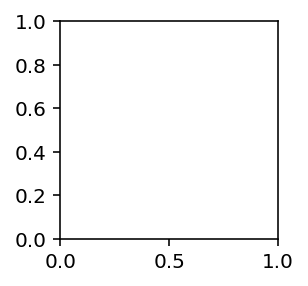

In [45]:
# ANIMATE ROTATION

%matplotlib qt

fig = plt.figure(figsize=(2,2))
aa = np.asarray(star_cube[:,:,0])
img_ = plt.imshow(aa, animated=True, cmap='hot', vmin=-1., vmax=1.)

def updatefig(i):
    aa = np.asarray(star_cube[:,:,i])
    img_.set_array(aa)
#    print(i)
    return img_,

anim = animation.FuncAnimation(fig, updatefig, interval=10, blit=True, save_count=number_of_rotation_phases)
plt.axis('off')
#plt.show()

In [46]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)
anim.save('rotate_.mp4', writer=writer)

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [47]:
xxxx

NameError: name 'xxxx' is not defined

In [48]:
phase_ = phase_transit_load.flatten()

pp_tmp_ = Degrees_stellar_rotation_per_HST_orbit_/observations_per_orbit_
phases_per_orbit_ = np.zeros((len(phase_),observations_per_orbit_))

print(phases_per_orbit_.shape)

for pp_ in range(len(phase_)):
#    print(pp_)
    phases_per_orbit_[pp_,:] = phase_[pp_] + (pp_tmp_)*np.linspace(-observations_per_orbit_/2,
                                                                               observations_per_orbit_/2,observations_per_orbit_)

aa = fig_full_lc_(phase_full_rotation, lc_full, phases_per_orbit_, lc_transit, nn, ii, save_fig)

NameError: name 'phase_transit_load' is not defined

In [3]:
'hello'.replace('l', 'i')

'heiio'

In [5]:
import pandas as pd

In [11]:
q = pd.Series({'x': 'hello'})

In [12]:
q.x.replace('h', 'i')

'iello'